Họ và tên: Phạm Đức Thể

MSSV: 19522253

Lớp: DS310.M11

Lab 03 - 28/10/2021

# Câu 1: Sử dụng mô hình LSTM để giải quyết bài toán NER cho tiếng Anh.

## Bước 1: Import Modules

In [1]:
# %matplotlib inline
import matplotlib.pyplot as plt
from io import BytesIO
import pandas as pd
import seaborn as sn
import numpy as np
import requests
np.random.seed(0)
plt.style.use("ggplot")
import tensorflow as tf
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.7.0
GPU detected: []


## Bước 2: Load bộ dữ liệu NER

Thông tin các thực thể:

geo = Geographical Entity\
org = Organization\
per = Person\
gpe = Geopolitical Entity\
tim = Time indicator\
art = Artifact\
eve = Event\
nat = Natural Phenomenon

Sau khi đọc tập dữ liệu, chúng ta quan sát thử 50 dòng đầu tiên như thế nào.


In [2]:
data = pd.read_csv('/content/drive/MyDrive/Dataset/ner_dataset.csv',encoding="latin1")
data = data.fillna(method="ffill")
data.head(50)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


## Visualizing the Sentenceentence
Thông kê bộ dữ liệu:
- Số lượng từ duy nhất trong kho ngữ liệu. (Tập từ vựng, số chiều)
- Số lượng thẻ duy nhất trong tập dữ liệu. (Tập nhãn)


Bằng cách sử dụng hàm **“nunique”.**

In [3]:
print("Unique words in corpus:", data['Word'].nunique())
print("Unique tags in corpus:", data['Tag'].nunique())

Unique words in corpus: 35178
Unique tags in corpus: 17


Tạo một danh sách và sử dụng phương thức set() để lấy các giá trị trong cột “word” và loại bỏ giá trị trùng.\
Thêm phần đệm có tên “Endpad”.


In [4]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
num_words = len(words)

In [5]:
print(words)
print(num_words)

['Two-time', 'struggles', 'Neverland', 'Malaya', 'Pennsylvania', 'pets', 'drafted', 'battery', 'lower', 'Palestinians', 'seaside', 'drastically', 'cost-reduction', 'concubines', '1,60,000', 'owed', '212-to-206', 'demotions', 'signings', 'raged', 'Angelina', 'Yuvraj', 'Sanjaya', 'rationale', 'guest-worker', 'rowers', 'commits', 'Dennis', 'provoke', '6', 'banned', 'employed', 'earthen', 'Clothes', 'market-share', 'Seydou', '22nd', 'salesman', 'Carroll', 'Frears', 'forgiveness', 'underlined', 'foundations', 'implicate', 'forums', 'high-priced', 'Kalfin', 'Restrictions', 'Storm', 'sportscar', 'quelling', 'Erik', 'Vanunu', 'Nominees', 'bill', 'Clinton-era', 'overcharges', 'feminist', '1652', 'baby', 'Chest', 'erect', 'hard-living', 'Norm', 'vacancy', 'midfield', 'quick', 'well-documented', 'Guanglie', 'preclude', 'Hartmann', 'weightlifting', 'anticorruption', 'Counsel', 'deployment', '17-meters', 'Anyama', 'addition', 'combines', 'deterrent', 'Kidwai', 'budgets', 'capability', 'invent', 'be

In [6]:
tags = list(set(data["Tag"].values))
num_tags = len(tags)

In [7]:
print(tags)

['O', 'I-org', 'B-org', 'B-geo', 'B-tim', 'B-art', 'B-eve', 'I-nat', 'B-per', 'I-art', 'B-gpe', 'I-gpe', 'I-tim', 'I-per', 'I-eve', 'B-nat', 'I-geo']


In [8]:
print('Tổng số từ duy nhất:', num_words)
print('Số lượng nhãn thực thể:', num_tags)

Tổng số từ duy nhất: 35179
Số lượng nhãn thực thể: 17


## Bước 3: Lấy các câu và các thẻ tương ứng

In [9]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

#các bạn có thể viết theo cách khác

In [10]:
getter = SentenceGetter(data)
sentences = getter.sentences

In [11]:
sentences[1]

[('Iranian', 'JJ', 'B-gpe'),
 ('officials', 'NNS', 'O'),
 ('say', 'VBP', 'O'),
 ('they', 'PRP', 'O'),
 ('expect', 'VBP', 'O'),
 ('to', 'TO', 'O'),
 ('get', 'VB', 'O'),
 ('access', 'NN', 'O'),
 ('to', 'TO', 'O'),
 ('sealed', 'JJ', 'O'),
 ('sensitive', 'JJ', 'O'),
 ('parts', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('the', 'DT', 'O'),
 ('plant', 'NN', 'O'),
 ('Wednesday', 'NNP', 'B-tim'),
 (',', ',', 'O'),
 ('after', 'IN', 'O'),
 ('an', 'DT', 'O'),
 ('IAEA', 'NNP', 'B-org'),
 ('surveillance', 'NN', 'O'),
 ('system', 'NN', 'O'),
 ('begins', 'VBZ', 'O'),
 ('functioning', 'VBG', 'O'),
 ('.', '.', 'O')]

## Bước 4: Ánh xạ giữa các câu và chỉ mục
Chúng ta có thể thấy rằng mỗi từ được gán cho một thẻ duy nhất. Chúng tôi có thể truy xuất những từ này bằng cách sử dụng các chỉ số của chúng và tra cứu chúng trong từ điển và trả về các khóa tương ứng.


In [12]:
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [13]:
# word2idx
# word2idx["ENDPAD"]
tag2idx 

{'B-art': 5,
 'B-eve': 6,
 'B-geo': 3,
 'B-gpe': 10,
 'B-nat': 15,
 'B-org': 2,
 'B-per': 8,
 'B-tim': 4,
 'I-art': 9,
 'I-eve': 14,
 'I-geo': 16,
 'I-gpe': 11,
 'I-nat': 7,
 'I-org': 1,
 'I-per': 13,
 'I-tim': 12,
 'O': 0}

## Bước 5: Padding  đầu vào và cắt dữ liệu thành tập Train/Test
Trong trục X, có thể thấy độ dài an toàn của câu là khoảng 50.

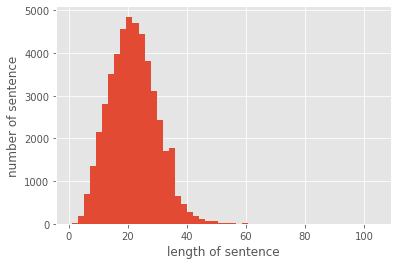

In [14]:
plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel("length of sentence")
plt.ylabel('number of sentence')
plt.show()

- Sử dụng hàm pad_sequence() cho padding
- X sẽ là một đại diện bằng số cho các từ. (sử dụng word2idx)
- ‘Post’ chỉ là một giá trị của đối số đệm ở cuối câu.
- X,y là vector

In [15]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_len = 50
X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=num_words-1)
y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

In [16]:
print(X[0])
print(y[0])

[ 5747 26134  1773  8082 32495 26531 21234 15624  8696 31452  3055 13623
 11395 11188 25232 31452 23818 26134 14819 11174 31141 26702 33697 14763
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178]
[ 0  0  0  0  0  0  3  0  0  0  0  0  3  0  0  0  0  0 10  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0]


- test_size = 0.2 có nghĩa là 80% dữ liệu chia cho tập huấn luyện và 20% còn lại cho tập kiểm tra.

In [17]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

## Bước 6: Xây dựng Mô hình GRU hai chiều (bi-GRU)


In [18]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import GRU, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

Bản tóm tắt cho thấy rằng chúng ta có hơn 1,88 triệu tham số cần được huấn luyện.

In [19]:
input_word = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=50, input_length=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(GRU(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags, activation="softmax"))(model)
model = Model(input_word, out)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 50)            1758950   
                                                                 
 spatial_dropout1d (SpatialD  (None, 50, 50)           0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 50, 200)          91200     
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 50, 17)           3417      
 ibuted)                                                         
                                                             

- Sử dụng trình tối ưu hoá "adam"
- sparce_categorical_crossentropy làm hàm mất mát
- Ma trận mà chúng ta sẽ quan tâm là ma trận độ chính xác.

In [20]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
# Dừng sớm để tránh overfitting
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

## Bước 7: Huấn luyện Model

- Để bắt đầu huấn luyện là gọi model.fit ()
- Có thể tăng kích thước batch_size nếu bạn có GPU có kích thước bộ nhớ lớn.



In [21]:
# Các bạn nhớ là phải lưu mô hình khi train (có nhắc lại yêu cầu ở cuối) 
import time
start_time = time.time()

history = model.fit(x_train, y_train, validation_split= 0.1,
                    batch_size= 32, epochs=10, callbacks=[callback])

print("[{}] Completed!".format(time.time() - start_time))

Epoch 1/10
1080/1080 [==============================] - 195s 176ms/step - loss: 0.1658 - accuracy: 0.9647 - val_loss: 0.0555 - val_accuracy: 0.9837
Epoch 2/10
1080/1080 [==============================] - 188s 174ms/step - loss: 0.0460 - accuracy: 0.9863 - val_loss: 0.0468 - val_accuracy: 0.9857
Epoch 3/10
1080/1080 [==============================] - 188s 174ms/step - loss: 0.0349 - accuracy: 0.9893 - val_loss: 0.0457 - val_accuracy: 0.9862
Epoch 4/10
1080/1080 [==============================] - 188s 174ms/step - loss: 0.0291 - accuracy: 0.9907 - val_loss: 0.0458 - val_accuracy: 0.9861
Epoch 5/10
1080/1080 [==============================] - 188s 174ms/step - loss: 0.0251 - accuracy: 0.9919 - val_loss: 0.0467 - val_accuracy: 0.9860
Epoch 6/10
1080/1080 [==============================] - 188s 174ms/step - loss: 0.0221 - accuracy: 0.9927 - val_loss: 0.0498 - val_accuracy: 0.9857
Epoch 7/10
1080/1080 [==============================] - 187s 173ms/step - loss: 0.0195 - accuracy: 0.9935 - val_

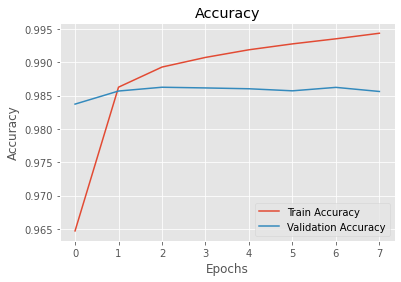

In [22]:
plt.plot(history.history['accuracy'], label = 'Train Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

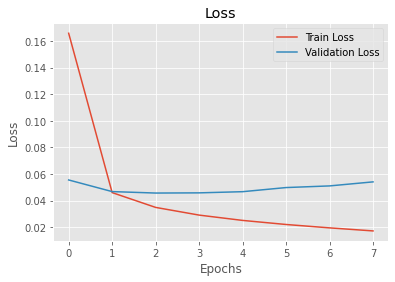

In [23]:
plt.plot(history.history['loss'], label = 'Train Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Bước 8: Đánh giá mô hình NER



In [24]:
model.evaluate(x_test, y_test)

300/300 [==============================] - 7s 24ms/step - loss: 0.0480 - accuracy: 0.9858


[0.048001937568187714, 0.9857965111732483]

- Dự đoán

In [25]:
# i = np.random.randint(0, x_test.shape[0]) #659
print(x_test[1])
i = 2
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)
y_true = y_test[i]
print("{:25}{:5}\t {}\n".format("Word", "True", "Pred"))
print("-" *30)
for w, true, pred in zip(x_test[i], y_true, p[0]):
    print("{:25}{:5}\t{}".format(words[w-1], tags[true], tags[pred]))

[24916 27391  9889  1994  6550 10813 27291  7034 14242 16847 14285 24610
 12915 17437 11429 10813 11440 25552 17437 12915 11848  2622  4499  8825
 17438 23729 14763  2622 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178]
Word                     True 	 Pred

------------------------------
nosedive                 O    	O
Nominees                 O    	O
Hermitage                O    	O
eight-legged             O    	O
eating                   O    	O
al-Qidwa                 O    	O
resealed                 O    	O
reactions                B-geo	B-org
four-point               I-geo	I-org
record-high              O    	O
suppressed               O    	O
Torrential               O    	O
sang                     O    	O
demolished               B-tim	B-tim
alias                    O    	O
rough                    O    	O
rough                    O    	O
rough                    O    	O
rough              

## Bước 9: Yêu cầu

### Đánh giá mô hình theo độ đo F1-score

In [26]:
!pip install seqeval

     |████████████████████████████████| 43 kB 1.7 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16181 sha256=eace4bb1c6c9efaf956956e43b6063b8bc7d138535c4d77df8a400ceb93822c2
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


predict tập test

In [27]:
y_true = []
y_pred = []
for i in range(y_test.shape[0]):
  y_true.append(y_test[i])
  p = model.predict(np.array([x_test[i]]))
  p = np.argmax(p, axis=-1)
  y_pred.extend(p)

In [28]:
Y_true = []
Y_pred = []

for i, j in zip(range(len(y_true)), range(len(y_pred))):
  true = []
  pred = []
  for k in range(len(y_true[i])):
    true.append(tags[y_true[i][k]])
    pred.append(tags[y_pred[j][k]])
  Y_true.append(true)
  Y_pred.append(pred)

In [29]:
from seqeval.metrics import f1_score

print('F1-score micro test set: {}%'.format(round(f1_score(Y_true, Y_pred, average='micro')*100,2)))
print('F1-score macro test set: {}%'.format(round(f1_score(Y_true, Y_pred, average='macro')*100,2)))

F1-score micro test set: 81.06%
F1-score macro test set: 54.06%


### F1-score và Accuracy cho từng nhãn thực thể. 

#### F1-score

In [30]:
from collections import Iterable
def flatten(lis):
     for item in lis:
         if isinstance(item, Iterable) and not isinstance(item, str):
             for x in flatten(item):
                 yield x
         else:        
             yield item

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  """Entry point for launching an IPython kernel.


In [31]:
YT = list(flatten(Y_true))
YP = list(flatten(Y_pred))

In [32]:
from sklearn.metrics import classification_report as sklearn_cs

print(sklearn_cs(YT, YP))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       B-art       0.00      0.00      0.00        96
       B-eve       0.86      0.08      0.14        79
       B-geo       0.89      0.85      0.87      7380
       B-gpe       0.95      0.94      0.95      3173
       B-nat       0.60      0.08      0.14        38
       B-org       0.76      0.74      0.75      3908
       B-per       0.82      0.83      0.82      3359
       B-tim       0.90      0.88      0.89      4102
       I-art       0.00      0.00      0.00        86
       I-eve       0.67      0.03      0.05        73
       I-geo       0.84      0.75      0.79      1449
       I-gpe       0.89      0.52      0.65        33
       I-nat       0.00      0.00      0.00        12
       I-org       0.82      0.76      0.79      3254
       I-per       0.86      0.84      0.85      3424
       I-tim       0.83      0.73      0.78      1339
           O       0.99      1.00      1.00    447795

    accuracy              

In [33]:
from seqeval.metrics import classification_report as seqeval_cs

print(seqeval_cs(Y_true, Y_pred, digits =4))

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         art     0.0000    0.0000    0.0000        96
         eve     0.6000    0.0759    0.1348        79
         geo     0.8694    0.8440    0.8565      7380
         gpe     0.9522    0.9411    0.9466      3173
         nat     0.6000    0.0789    0.1395        38
         org     0.6632    0.6817    0.6723      3908
         per     0.7059    0.7423    0.7236      3360
         tim     0.8497    0.8530    0.8513      4102

   micro avg     0.8134    0.8078    0.8106     22136
   macro avg     0.6550    0.5271    0.5406     22136
weighted avg     0.8112    0.8078    0.8083     22136



#### Accuracy

In [34]:
from seqeval.metrics import accuracy_score

accuracy = round(accuracy_score(Y_true, Y_pred)*100,2)
print('Accuracy test = {}%'.format(accuracy))

Accuracy test = 98.58%


Confusion matrix với các nhãn tương ứng như sau

B-art - 0    
B-eve - 1      
B-geo - 2      
B-gpe - 3      
B-nat - 4      
B-org - 5      
B-per - 6      
B-tim - 7      
I-art - 8     
I-eve - 9      
I-geo - 10      
I-gpe - 11      
I-nat - 12      
I-org - 13      
I-per - 14      
I-tim - 15      
O     - 16  

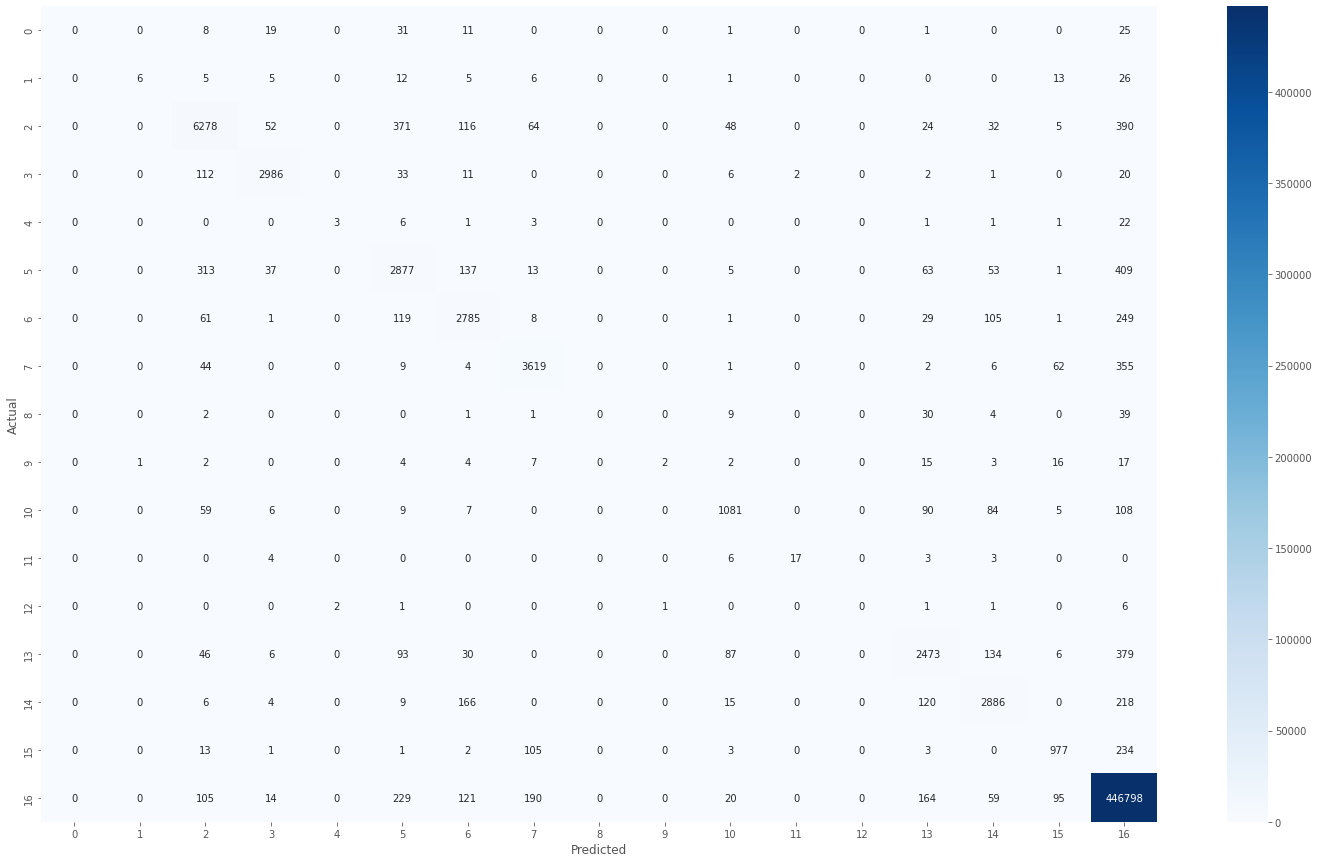

In [35]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(YT, YP) 
plt.figure(figsize=(25,15))
sn.heatmap(cm, annot=True, cmap = 'Blues', fmt='g', cbar=True, annot_kws={"size": 10})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [36]:
labels=["B-art", "B-eve", "B-geo", "B-gpe", "B-nat", "B-org", "B-per", "B-tim", 
        "I-art", "I-eve", "I-geo", "I-gpe", "I-nat", "I-org", "I-per", "I-tim", "O"]
# Accuracy của từng nhãn thực thể
acc_class = cm.diagonal()/cm.sum(axis=1) 
df_acc_class = pd.DataFrame({'Label': labels,
                             'Accuracy': acc_class})
df_acc_class

,Label,Accuracy
0,B-art,0.000000
1,B-eve,0.075949
2,B-geo,0.850678
3,B-gpe,0.941065
4,B-nat,0.078947
5,B-org,0.736182
6,B-per,0.829116
7,B-tim,0.882253
8,I-art,0.000000
9,I-eve,0.027397


### Lưu lại mô hình và bộ trọng số đã train. 

In [37]:
# Chuyển đến thư mục cần lưu model
%cd '/content/drive/MyDrive/TÀI LIỆU HỌC TẬP ĐẠI HỌC 2019-2023/NĂM 3 2021-2022/HỌC KỲ 1 2021 - 2022/DS310.M11 - XỬ LÝ NGÔN NGỮ TỰ NHIÊN CHO KHOA HỌC DỮ LIỆU/THỰC HÀNH/LAB/LAB04 28 10 2021'

/content/drive/MyDrive/TÀI LIỆU HỌC TẬP ĐẠI HỌC 2019-2023/NĂM 3 2021-2022/HỌC KỲ 1 2021 - 2022/DS310.M11 - XỬ LÝ NGÔN NGỮ TỰ NHIÊN CHO KHOA HỌC DỮ LIỆU/THỰC HÀNH/LAB/LAB04 28 10 2021


In [38]:
pwd

'/content/drive/MyDrive/TÀI LIỆU HỌC TẬP ĐẠI HỌC 2019-2023/NĂM 3 2021-2022/HỌC KỲ 1 2021 - 2022/DS310.M11 - XỬ LÝ NGÔN NGỮ TỰ NHIÊN CHO KHOA HỌC DỮ LIỆU/THỰC HÀNH/LAB/LAB04 28 10 2021'

In [39]:
ls

BTTH3_19522253.pdf                 NER_Câu2_GRU_19522253_model.h5
NER_Câu1_GRU_19522253.ipynb        NER_Câu2_GRU_19522253_weights.h5
NER_Câu1_GRU_19522253_model.h5     NER_Câu2_LSTM_19522253.ipynb
NER_Câu1_GRU_19522253_weights.h5   NER_Câu2_LSTM_19522253_model.h5
NER_Câu1_LSTM_19522253.ipynb       NER_Câu2_LSTM_19522253_weights.h5
NER_Câu1_LSTM_19522253_model.h5    NER_Câu2_RNN_19522253_model.h5
NER_Câu1_LSTM_19522253_weights.h5  NER_Câu2_RNN_19522253_weights.h5
NER_Câu1_RNN_19522253_model.h5     ner_dataset.csv
NER_Câu1_RNN_19522253_weights.h5   NER-LSTM.ipynb
NER_Câu2_GRU_19522253.ipynb


In [40]:
# Lưu bộ trọng số đã train
model.save_weights('NER_Câu1_GRU_19522253_weights.h5')

In [41]:
# Lưu mô hình đã train
model.save('NER_Câu1_GRU_19522253_model.h5')